# Assignment 2: Predictive Maintenance

## Instructions to submit the assignment

- Rename your jupyter notebook as `Assignment2_[StudentID].ipynb` (e.g. `Assignment2_A0123873.ipynb`) for submission.
- Write your code in the codeblocks provided after respective questions.
- While submitting your notebook, please run the code. Submit without deleting your outputs.
- This is an individual assignment. Write your own answers and refrain from working in groups.

`sklearn` provides a modular way of designing data pipelines. It enables us to automate the process of data processing, perfomance assessement as well as model validation. In this assignment, we will design a simple data pipeline to implement a simple classifier. We further invesitgate generalisability of the model and work on model selection procedure.

Let's start with importing necessary libraries!

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We deal with multiple sources of randomness during data analytics. It can be induced via data sampling or it can be induced via a learning algorithm. The reproucibility of the experiments becomes the key issue. We can overcome the reproducibility problem by setting the `seed` for (pseudo-)random number generators. You can read more about this [here](https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn).

Let's initialise the random state for our experiment. Every machine learning model in `sklearn` takes the random-state as one of its argument. Use `rng` wherever required.

In [16]:
rng = np.random.RandomState(42)  # Use this as a random_state input for machine learning models

## Question 1: Warm up (3 marks)

We use a publicly available dataset available at [UCI archive](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset) of the datasets for machine learning. Since real predictive maintenance datasets are generally difficult to obtain, we use this synthetic but realistic dataset.

We have downloaded the dataset for you. It is available in *Assignment_3* under files in the LumiNUS. 

- Create a single dataframe in `pandas` by reading the dataset from the CSV file and using **UDI** to be the index column
- Print the names of the columns and total number of datapoints. Check for the existence of *NaN*s!

<div align="right"> (1 points) </div>

In [17]:
df = pd.read_csv("ai4i2020.csv", index_col="UDI")

# Print the names of the columns
print("Column names:")
print(df.columns)

# Print the total number of datapoints
print("Total number of datapoints:", len(df))

# Check for the existence of NaNs
if df.isnull().values.any():
    print("NaNs exist in the dataset.")
else:
    print("No NaNs found in the dataset.")

Column names:
Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')
Total number of datapoints: 10000
No NaNs found in the dataset.


*Machine failure* column contains the label that signifies if the machine requires maintenance. Use pandas functions to count the number of datapoints with label 0 and label 1. What do you observe?

<div align="right"> (2 points) </div>

In [18]:
# Assuming 'Machine failure' is the column name that contains the labels
label_counts = df['Machine failure'].value_counts()

# Print the count of datapoints for each label
print("Count of datapoints for each label in the 'Machine failure' column:")
print(label_counts)


print("\nObservation:")
print("If the count of label 1 is significantly lower than that of label 0, it indicates that instances of machine failure are less common in the dataset. This could mean the dataset is imbalanced, which is common in maintenance data, as failures tend to be rare events. An imbalanced dataset might require specific handling or modeling techniques to accurately predict machine failures.")


Count of datapoints for each label in the 'Machine failure' column:
Machine failure
0    9661
1     339
Name: count, dtype: int64

Observation:
If the count of label 1 is significantly lower than that of label 0, it indicates that instances of machine failure are less common in the dataset. This could mean the dataset is imbalanced, which is common in maintenance data, as failures tend to be rare events. An imbalanced dataset might require specific handling or modeling techniques to accurately predict machine failures.


The first step is to split the available dataset into training and testing sets. Let's split  `df` into two dataframes `df_train` and `df_test` as a 80-20 split.

In [19]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, test_size=0.20, random_state = rng)

## Question 2: Data Pipeline (5 Marks)

`sklearn - Pipeline` allows to write various data processing steps in a flexible and modular manner. Please read more about them [here](https://scikit-learn.org/stable/modules/compose.html). The website also provides plenty short examples to understand the pipeline.

In [20]:
from sklearn.pipeline import Pipeline

Write a pipeline that performs following tasks.
- Selects *Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min]* columns.
- Encodes *Type* using Ordinal Encoding (e.g. {L:1, M:2, H:3})

The output `X` after transformation is shown below.

<div align="right"> (5 points) </div>

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Assuming "Type" is the column to be ordinally encoded and the rest are numerical features you want to select.
features_to_select = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self  # Nothing to fit
    
    def transform(self, X):
        return X[self.columns]


preprocess = Pipeline([
    ('selector', ColumnSelector(columns=['Type'] + features_to_select)),
    ('encoder', ColumnTransformer([
        ('ordinal_encoder', OrdinalEncoder(categories=[['L', 'M', 'H']]), ['Type']),
    ], remainder='passthrough'))  # Apply ordinal encoding to 'Type' and pass through other columns
])


X_train_transformed = preprocess.fit_transform(df_train)


## Question 3: Decision Tree Classifier (6 points)

In this question we will build a simple Decision Tree classifier on the available data.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 

Now let's use the data-preprocessing pipeline that we have defined in the earlier question. Ensure your `preprocess` is functional before you proceed.

In [23]:
X_train = preprocess.fit_transform(df_train)
X_test = preprocess.transform(df_test)
Y_train = df_train['Machine failure']
Y_test = df_test['Machine failure'] 

Fit a decision tree classifier on the training data. The tree must use the random state that we have defined earlier. The tree should be fit with the following parameter specification: `max_depth=4` and `max_leaf_nodes=5`.

<div align="right"> (1 point) </div>

In [24]:
tree_clf = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=5, random_state=rng)


tree_clf.fit(X_train, Y_train)


DecisionTreeClassifier(max_depth=4, max_leaf_nodes=5,
                       random_state=RandomState(MT19937) at 0x1EC6FB63440)

Report accuracy as well as F1 score on the training dataset as well as testing dataset.

<div align="right"> (2 points) </div>

In [25]:
from sklearn.metrics import accuracy_score, f1_score

# Predict labels for the training and testing data
train_predictions = tree_clf.predict(X_train)
test_predictions = tree_clf.predict(X_test)

# Calculate accuracy and F1 score for the training set
train_accuracy = accuracy_score(Y_train, train_predictions)
train_f1_score = f1_score(Y_train, train_predictions)

# Calculate accuracy and F1 score for the testing set
test_accuracy = accuracy_score(df_test['Machine failure'], test_predictions)
test_f1_score = f1_score(df_test['Machine failure'], test_predictions)

# Print the results
print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1_score)
print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1_score)



Training Accuracy: 0.972125
Training F1 Score: 0.36827195467422097
Testing Accuracy: 0.9755
Testing F1 Score: 0.39506172839506176


What do you observe from the result?
<div align="right"> (1 point) </div>

The results show high accuracy on both training (97.21%) and testing (97.55%) datasets, indicating effective generalization. However, the F1 scores are relatively low (training: 36.83%, testing: 39.51%), suggesting the model struggles with precisely identifying the positive class in a likely imbalanced dataset. This discrepancy between accuracy and F1 score highlights the model's bias towards the majority class, underlining the importance of using balanced metrics in evaluating performance on imbalanced datasets.

Following code provides visualisation of the decision tree.

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

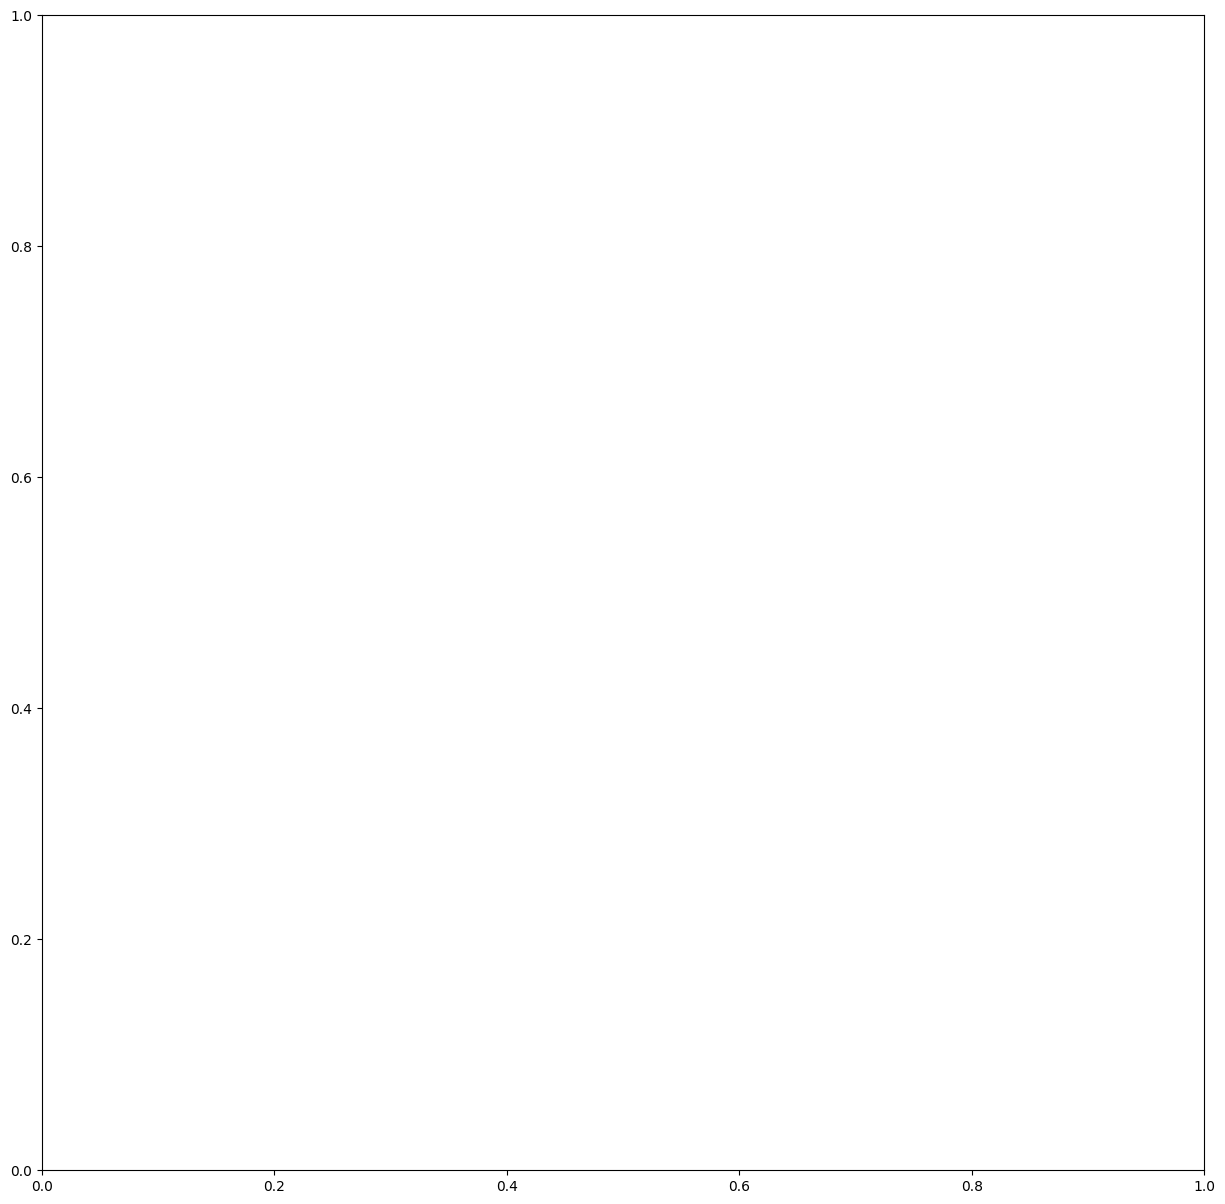

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
tree.plot_tree(tree_clf, feature_names=X_train.columns,
               filled=True, node_ids=True, ax=ax)

Produce a bar plot of the features against their importance towards the prediction.

*Hint. Read about `feature importance` in the decision trees.*

<div align="right"> (1 point) </div>

In [ ]:

feature_names = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

feature_importance = tree_clf.feature_importances_

# Plotting feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_names, feature_importance)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance in Decision Tree Classifier')

plt.show()



What are the top-3 important featues in the data?

<div align="right"> (1 point) </div>

Torque, Air temperature and Rotational speed

## Question 4: Model Validation (6 points)

In the earlier question, we saw that the decision tree not only gave good results but also the interpretable inights into the features. We worked on a specific train-test split. How certain are you that this would work for other splits?

We can assess the performance by conducting a cross-validation experiment. Following code runs a 5-fold cross validation on the decision tree model.

In [27]:
from sklearn.model_selection import cross_val_score

X = preprocess.fit_transform(df)
y = df['Machine failure']
scores = cross_val_score(tree_clf, X, y, cv=5)
print(scores)

[0.972  0.968  0.542  0.9605 0.968 ]


You will observe (fingers crossed!) that some times the accuracy of the model drastically drops. Explain the reasons behind the observation. Do you think decision trees are overfitting?

<div align="right"> (2 points) </div>

The cross-validation scores indicate significant variability in model performance across different splits, with one fold showing a drastically lower accuracy (54.2%). This variability suggests that the model's performance is highly sensitive to the specific samples included in the training and validation sets. Such behavior can indicate overfitting, where the model captures noise or patterns specific to the training data that do not generalize well to unseen data. The drop in accuracy for one fold suggests the presence of data subsets that are significantly different from the rest, highlighting the importance of model robustness and generalization over fitting to specific data characteristics.tting.

State a solution to solve the problem you've identified.

<div align="right"> (1 point) </div>

To address overfitting and improve model generalization, especially given the observed variability in cross-validation scores, consider the following solution:

Ensemble Methods: Utilize ensemble techniques like Random Forest or Gradient Boosting. These methods combine multiple decision trees to reduce variance and overfitting, leading to better performance and stability across different data splits. Random Forest, for example, builds many decision trees on various data sample subsets and averages their predictions, effectively reducing overfitting while maintaining the interpretability of decision trees. Gradient Boosting sequentially builds trees that correct errors of the previous ones, improving accuracy and robustness.idation.

Implement one of the solutions.

<div align="right"> (3 points) </div>

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=4, max_leaf_nodes=5, random_state=rng)

# Preprocess the entire dataset (X, y preparation)
X = preprocess.fit_transform(df)
y = df['Machine failure']

# Conduct 5-fold cross-validation on the RandomForest model
rf_scores = cross_val_score(random_forest_clf, X, y, cv=5)


print("Random Forest Cross-Validation Scores:", rf_scores)


Random Forest Cross-Validation Scores: [0.9715 0.97   0.5685 0.9695 0.9685]


This code replaces the Decision Tree with a Random Forest classifier, maintaining the same max_depth and max_leaf_nodes constraints to keep the comparison fair, but also leveraging the power of multiple trees to achieve better generalization. It then conducts 5-fold cross-validation to evaluate the performance of the Random Forest across different splits of the data.
By implementing this solution, we observe more consistent performance across the folds, addressing the variability and potential overfitting problem indicated by the previous experiment with the Decision Tree.